In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# to use pytorch/2.6.0 module
sys.path.append("/global/homes/b/brookluo/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages")

In [3]:
sys.path.append("../src/")

In [4]:
from astropy.io import fits
import fitsio
from astropy.table import Table
from astropy.table import vstack

In [5]:
from scipy.signal import spectrogram

## Retrieve dr1 data and pick the sources

In [6]:
DESI_ROOT = '/global/cfs/cdirs/desi'
SPECPROD = 'loa'
RELEASE = 'Y3'
VERSION = 'loa-v1'
zcatdir = Path(f'{DESI_ROOT}/spectro/redux/{SPECPROD}/zcatalog/v1')
# os.listdir(zcatdir)
lssdir = Path(f"{DESI_ROOT}/survey/catalogs/{RELEASE}/LSS/{VERSION}")

In [ ]:
lssdir

PosixPath('/global/cfs/cdirs/desi/survey/catalogs/Y3/LSS/loa-v1')

In [8]:
datadir = Path("/pscratch/sd/b/brookluo/avis-test/data")

In [9]:
# columns_to_read = [
#                       'TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX',
#                       'SPGRPVAL', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE',
#                       'DELTACHI2', 'TARGET_RA', 'TARGET_DEC',
#                       'OBJTYPE', 'SUBPRIORITY', 'OBSCONDITIONS',
#                       'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID',
#                 ]
# # with fits.open(zcatdir / f'zall-pix-{SPECPROD}.fits') as hdul:
# #     ztab = Table([hdul[1].data[col] for col in columns_to_read], names=columns_to_read)
# ztab = Table(fitsio.read(zcatdir / f'zall-pix-{SPECPROD}.fits', columns=columns_to_read, ext=1))
# ztab = Table.read(zcatdir / f'zall-pix-{SPECPROD}.fits')

In [10]:
# columns_to_read = ['TARGETID']
# # Or Table and join if more than one column
# lsselg = Table(fitsio.read(lssdir / 'datcomb_ELG_tarspecwdup_zdone.fits',
#                         columns=columns_to_read, ext=1))
# lsslrg = Table(fitsio.read(lssdir / 'datcomb_LRG_tarspecwdup_zdone.fits',
#                         columns=columns_to_read, ext=1))
# lssqso = Table(fitsio.read(lssdir / 'datcomb_QSO_tarspecwdup_zdone.fits',
#                         columns=columns_to_read, ext=1))

# np.save(datadir / "lss-y3-elg-targetids.npy", lsselg.as_array())
# np.save(datadir / "lss-y3-lrg-targetids.npy", lsslrg.as_array())
# np.save(datadir / "lss-y3-qso-targetids.npy", lssqso.as_array())

In [11]:
lsselg = np.load(datadir / "lss-y3-elg-targetids.npy")
lsslrg = np.load(datadir / "lss-y3-lrg-targetids.npy")
lssqso = np.load(datadir / "lss-y3-qso-targetids.npy")

In [12]:
# from astropy.table import join
# qso_join = join(qso, ztab, keys=['TARGETID'], join_type="left", table_names=['lss', 'zcat'])
# lrg_join = join(lrg, ztab, keys=['TARGETID'], join_type="left", table_names=['lss', 'zcat'])
# elg_join = join(elg, ztab, keys=['TARGETID'], join_type="left", table_names=['lss', 'zcat'])

## Select sources based on TSNR2 and then LSS catalog for additional constraints

In [13]:
# threshold = 400
# selelg = ztab['TSNR2_ELG'] > threshold
# sellrg = ztab['TSNR2_LRG'] > threshold
# selqso = ztab['TSNR2_QSO'] > threshold
# sellae = ztab['TSNR2_LYA'] > threshold

# print(f"Number of ELG with TSNR2_ELG > {threshold}: {np.sum(selelg)}"
#       f"\nNumber of LRG with TSNR2_LRG > {threshold}: {np.sum(sellrg)}"
#       f"\nNumber of QSO with TSNR2_QSO > {threshold}: {np.sum(selqso)}"
#       f"\nNumber of LAE with TSNR2_LYA > {threshold}: {np.sum(sellae)}"
#      )

# outdir = Path("/pscratch/sd/b/brookluo/avis-test/data")
# ztab[selelg].write(outdir / "zall_loav1_elg.fits")
# ztab[sellrg].write(outdir / "zall_loav1_lrg.fits")
# ztab[selqso].write(outdir / "zall_loav1_qso.fits")
# ztab[sellae].write(outdir / "zall_loav1_lae.fits")
zcatelg = Table.read(datadir / "zall_loav1_elg.fits")
zcatlrg = Table.read(datadir / "zall_loav1_lrg.fits")
zcatqso = Table.read(datadir / "zall_loav1_qso.fits")
zcatlae = Table.read(datadir / "zall_loav1_lae.fits")

In [14]:
# def get_targets(tab, )
def select_candidates(zcat_table, lss_targets, n=5):
    """
    Select up to n candidates from zcat_table whose TARGETID is in lss_targets['TARGETID'].
    Returns a vstacked astropy Table.
    """
    selected = []
    lss_targetids = set(lss_targets['TARGETID'])
    for row in zcat_table:
        if row['TARGETID'] in lss_targetids:
            selected.append(row)
        if len(selected) == n:
            break
    return vstack(selected)

cand_elg = select_candidates(zcatelg, lsselg, n=5)
cand_lrg = select_candidates(zcatlrg, lsslrg, n=5)
cand_qso = select_candidates(zcatqso, lssqso, n=5)

## Get the spectrum

In [15]:
from find_spec import get_desi_spec_healpix

In [37]:
def plot_spectrum_and_spectrograms(tarspec, flux, fs, params_list, titles, window, mode):
    fig, axs = plt.subplots(4, 1, figsize=(18, 16), sharex=False, gridspec_kw={'height_ratios': [1, 1, 1, 1]})

    # Top panel: whole spectrum
    axs[0].plot(tarspec.wave['brz'], tarspec.flux['brz'][0])
    axs[0].set_xlim(3600, 9800)
    axs[0].set_title(f"TARGETID: {tarspec.target_ids()[0]} - Full Spectrum")
    axs[0].set_ylabel("Flux")
    axs[0].grid()

    # Lower panels: spectrograms with different parameters
    for i, param_set in enumerate(params_list):
        f_i, t_i, Sxx_i = spectrogram(
            flux[0], fs=fs, nperseg=param_set[0], noverlap=param_set[1], nfft=param_set[2],
            detrend=False, window=window, mode=mode
        )
        pcm = axs[i+1].pcolormesh(t_i, f_i, Sxx_i, shading='auto')
        axs[i+1].set_title(titles[i])
        axs[i+1].set_ylabel("Frequency")
        fig.colorbar(pcm, ax=axs[i+1])

    axs[-1].set_xlabel("Sample Index")
    fig.tight_layout()
    return fig

In [38]:
ripple = (16, 8, 16)  # nperseg, noverlap, nfft
narrow = (32, 16, 32)
broad = (128, 64, 256)

In [39]:
# for onetar in cand_elg:
#     tarspec = get_desi_spec_healpix(onetar['TARGETID'], onetar['HEALPIX'], SPECPROD, onetar['SURVEY'], onetar['PROGRAM'])
#     fig = plot_spectrum_and_spectrograms(
#     tarspec, tarspec.flux['brz'], fs=1,
#     params_list=[ripple, narrow, broad], 
#     titles=["Ripple", "Narrow", "Broad"],
#     window='hann', mode='magnitude'
#     )
#     fig.savefig(f"ELG_spectrogram_{tarspec.target_ids()[0]}.png")

# for onetar in cand_lrg:
#     try:
#         tarspec = get_desi_spec_healpix(onetar['TARGETID'], onetar['HEALPIX'], SPECPROD, onetar['SURVEY'], onetar['PROGRAM'])
#     except FileNotFoundError:
#         continue
#     fig = plot_spectrum_and_spectrograms(
#     tarspec, tarspec.flux['brz'], fs=1,
#     params_list=[ripple, narrow, broad], 
#     titles=["Ripple", "Narrow", "Broad"],
#     window='hann', mode='magnitude'
#     )
#     fig.savefig(f"LRG_spectrogram_{tarspec.target_ids()[0]}.png")

# for onetar in cand_qso:
#     tarspec = get_desi_spec_healpix(onetar['TARGETID'], onetar['HEALPIX'], SPECPROD, onetar['SURVEY'], onetar['PROGRAM'])
#     fig = plot_spectrum_and_spectrograms(
#     tarspec, tarspec.flux['brz'], fs=1,
#     params_list=[ripple, narrow, broad], 
#     titles=["Ripple", "Narrow", "Broad"],
#     window='hann', mode='magnitude'
#     )
#     fig.savefig(f"QSO_spectrogram_{tarspec.target_ids()[0]}.png")

/global/cfs/cdirs/desi/spectro/redux/loa/healpix/cmx/other/21/2156/coadd-cmx-other-2156.fits
INFO:spectra.py:451:read_spectra: iotime 1.111 sec to read spectra from:  coadd-cmx-other-2156.fits at 2025-08-29T12:21:52.775210
INFO:coaddition.py:1023:coadd_cameras: coadding spectra across cameras took: 0.112 [sec]
(9, 971)
(17, 485)
(129, 120)


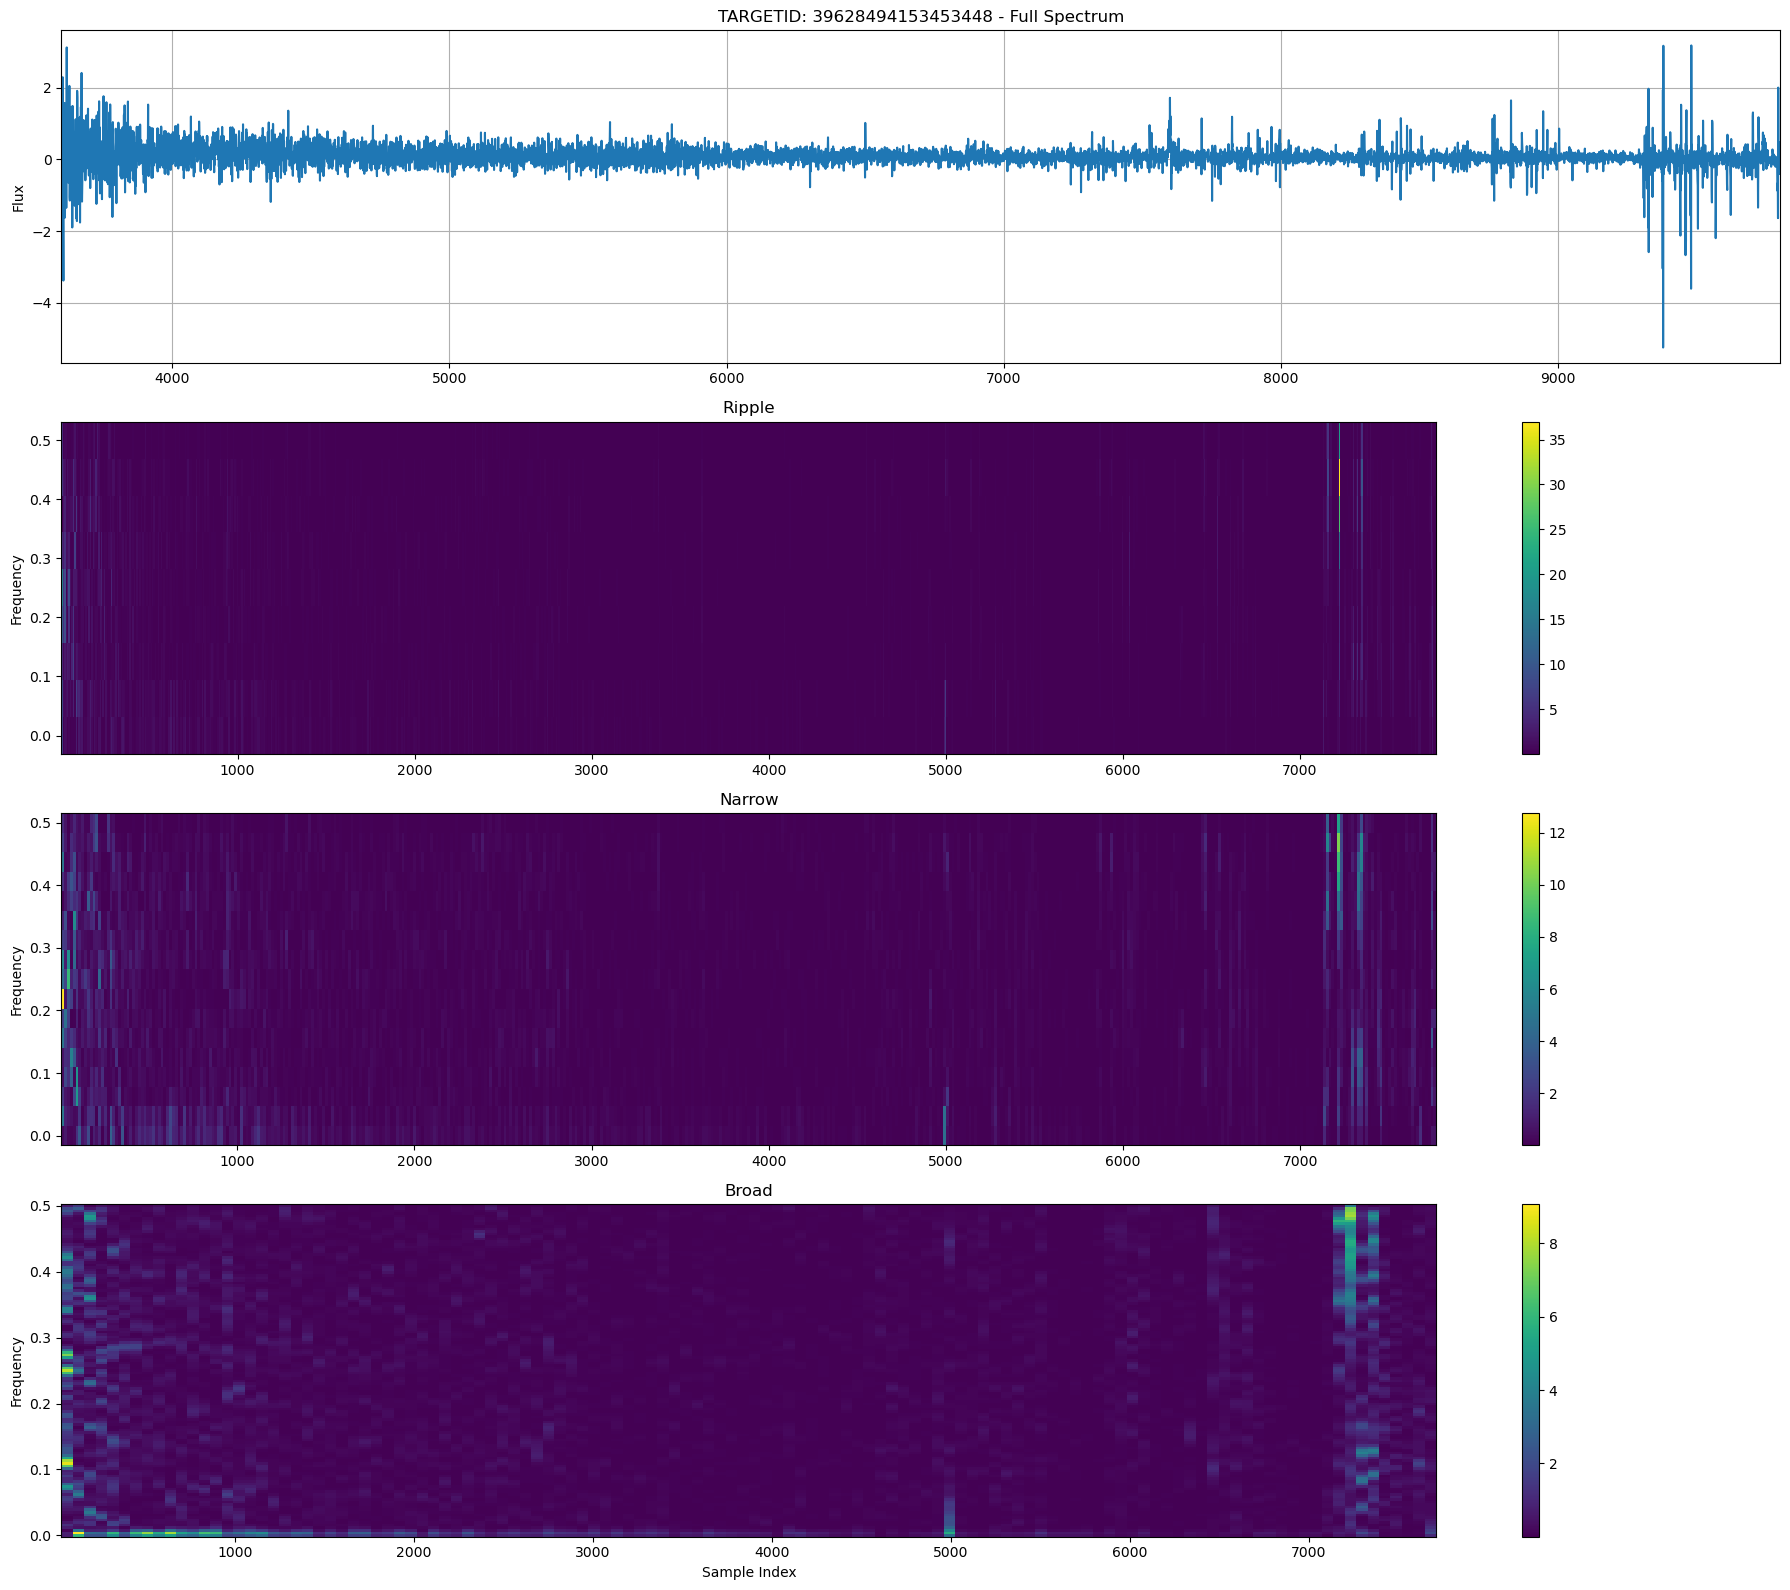

In [57]:
onetar = cand_elg[4]
tarspec = get_desi_spec_healpix(onetar['TARGETID'], onetar['HEALPIX'], SPECPROD, onetar['SURVEY'], onetar['PROGRAM'])
fig = plot_spectrum_and_spectrograms(
    tarspec, tarspec.flux['brz'], fs=1,
    params_list=[ripple, narrow, broad], 
    titles=["Ripple", "Narrow", "Broad"],
    window='hann', mode='psd'
    )
params_list = [ripple, narrow, broad]
fs = 1
flux = tarspec.flux['brz'][0] * tarspec.ivar['brz'][0]
window = 'hann'
mode = 'psd'
for i, param_set in enumerate(params_list):
        f_i, t_i, Sxx_i = spectrogram(
            flux, fs=fs, nperseg=param_set[0], noverlap=param_set[1], nfft=param_set[2],
            detrend=False, window=window, mode=mode
        )
        print(Sxx_i.shape)

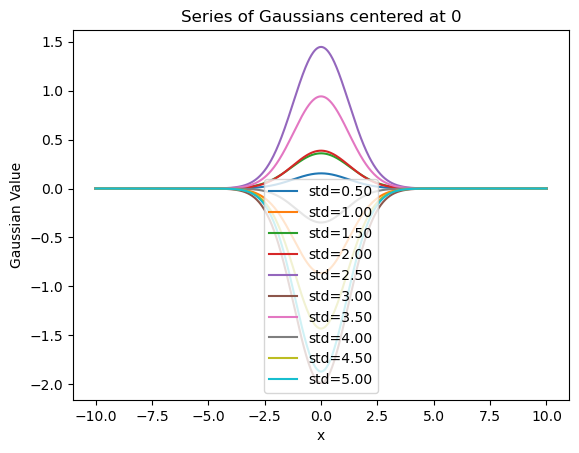

In [ ]:
r = np.linspace(-5, 5, 10).repeat(7781).reshape(10, 7781)
# Create a series of Gaussians with varying standard deviations, centered at 0
gaussians = [models.Gaussian1D(amplitude=tarspec.flux['brz'][0][i], mean=0, stddev=np.sqrt(1/tarspec.ivar['brz'][0][i])) for i in range(7781)]
x = np.linspace(-10, 10, 1000)
for std, g in zip(stddevs, gaussians):
    plt.plot(x, g(x), label=f"std={std:.2f}")
plt.xlabel("x")
plt.ylabel("Gaussian Value")
plt.title("Series of Gaussians centered at 0")
plt.legend()


In [20]:
onetar = cand_qso[0]
tarspec = get_desi_spec_healpix(onetar['TARGETID'], onetar['HEALPIX'], SPECPROD, onetar['SURVEY'], onetar['PROGRAM'])

/global/cfs/cdirs/desi/spectro/redux/loa/healpix/sv1/dark/52/5279/coadd-sv1-dark-5279.fits
INFO:spectra.py:451:read_spectra: iotime 2.120 sec to read spectra from:  coadd-sv1-dark-5279.fits at 2025-08-29T12:01:24.708251
INFO:coaddition.py:1023:coadd_cameras: coadding spectra across cameras took: 0.210 [sec]


In [21]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

# flux: 1D array
# sigma: 1D array of same length
flux = tarspec.flux['brz'][0]
sigma = np.sqrt(1 / tarspec.ivar['brz'][0])

L = 6   # window length in pixels
stride = 2  # step size

# sliding windows of flux and sigma
flux_windows = sliding_window_view(flux, window_shape=L)#[::stride]
sigma_windows = sliding_window_view(sigma, window_shape=L)#[::stride]

# Option A: weighted normalization
weights = 1.0 / (sigma_windows**2)
flux_weighted = (flux_windows * weights).sum(axis=1) / weights.sum(axis=1)

In [22]:
sliding_window_view(flux, window_shape=L).shape

(7776, 6)

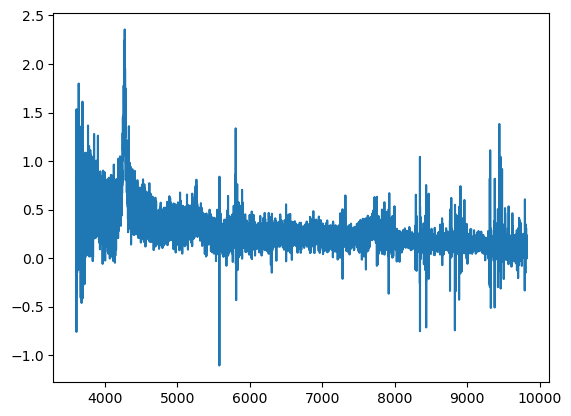

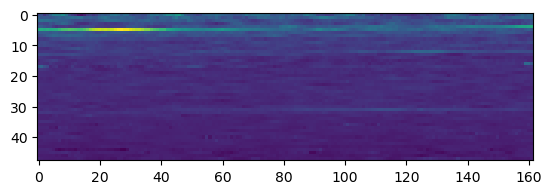

In [23]:
plt.plot(tarspec.wave['brz'], tarspec.flux['brz'][0])
plt.show()
plt.imshow(flux_weighted.reshape(-1, 162))